In [1]:
import sys
sys.path.append("../")

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import jvp, vjp
from jax import random

import jax
from functools import partial
from jax.ops import index_update, index

import matplotlib.pyplot as plt
import time
import numpy as np
import scipy as sp

from utils import generate_data_XOR

key = random.PRNGKey(2)
CTYPE = jnp.complex64
RTYPE = jnp.float32

%load_ext autoreload
%autoreload 2

### Network parameters

In [2]:
n_bit = 8
N_pad = 0
ports = n_bit+N_pad

depths = ports
layer = 2

n_mzi = int(ports*(ports-1)/2)

### Ring parameters

In [3]:
# coupling coefficients
r1 = 0.76676661
r2 = 0.97301454
r3 = r1
dx = 0
# ring aborption loss
a = 1

In [4]:
def get_location(ports, depths):
    pairs = []
    for layer in range(depths):
        pairs.append([])
        if layer % 2 == 0:
            j = 0
            while j < ports-1:
                pairs[layer].append([j, j+1])
                j += 2
        else:
            j = 1
            while j < ports-1:
                pairs[layer].append([j, j+1])
                j += 2
    return pairs

In [5]:
def ABCD(r, a, phi):
    # so now there is a splitter
    k = jnp.sqrt(1-r**2)
    A = -jnp.sqrt(a)/1j/k * jnp.exp(1j*phi/2)
    B = r*jnp.sqrt(a)/1j/k * jnp.exp(1j*phi/2)
    C = -r/1j/k/jnp.sqrt(a) * jnp.exp(-1j*phi/2)
    D = 1/1j/k/jnp.sqrt(a) * jnp.exp(-1j*phi/2)
    return jnp.array([[A, B], [C, D]])

def lastABCD(r):
    k = jnp.sqrt(1-r**2)
    trans = jnp.array([[-1, r], [-r, 1]], dtype=CTYPE)
    return 1./1j/k*trans

def doublering(phi):
    phi = phi + dx
    trans = jnp.dot(ABCD(r2, a, phi), ABCD(r1, a, phi))
    trans = jnp.dot(lastABCD(r3), trans)
#     print(trans)
    
    A = trans[0,0]
    B = trans[0,1]
    C = trans[1,0]
    D = trans[1,1]

    return -C/D, 1/D, A-B*C/D, B/D


In [6]:
def clements(phi_list, xin):
    count_mzi = 0
    xout = xin
    for layer in range(depths):
        T = np.eye(ports, dtype=CTYPE).tolist()
#         T = jnp.eye(ports, dtype=CTYPE)
    
        for ind_mzi in range(len(pairs[layer])):
            # this process makes things slower => change
            T11, T12, T21, T22 = doublering(phi_list[count_mzi])
            m, n = pairs[layer][ind_mzi]
            T[m][m] = T11
            T[m][n] = T12
            T[n][m] = T21
            T[n][n] = T22
            
            count_mzi += 1
        T = jnp.array(T)
        xout = jnp.dot(T, xout)
    return xout

def clements_print(phi_list, xin):
    count_mzi = 0
    xout = xin
    for layer in range(depths):
        T = jnp.eye(ports, dtype=CTYPE)
        
        for ind_mzi in range(len(pairs[layer])):
            # this process makes things slower => change
            T11, T12, T21, T22 = doublering(phi_list[count_mzi])
            m, n = pairs[layer][ind_mzi]
            # index_update is kinda slow
            T = index_update(T, index[m, m], T11)
            T = index_update(T, index[m, n], T12)
            T = index_update(T, index[n, m], T21)
            T = index_update(T, index[n, n], T22)
            count_mzi += 1
            print(f'clements{count_mzi}', jnp.abs(T11), jnp.abs(T21))
            print(f'xpass{count_mzi}', jnp.round(jnp.abs(jnp.dot(T, xout))**2, 2))
        xout = jnp.dot(T, xout)
    return xout

In [7]:
def activation(xout, threshold=0.3):    
    g = np.pi
    phi_b = 0
    alpha = 0.1
    a = 0.9
    r = 0.9
    # ring
    dphi = 0.5*g*jnp.abs(xout)**2 + 0.5*phi_b
    t_ring = jnp.exp(1j*(np.pi+dphi))*(a-r*jnp.exp(1j*dphi))/(1.-r*a*jnp.exp(1j*dphi))
    # xout = (1j * jnp.sqrt(1.0-alpha) * t_ring) * xout
    xout = jnp.abs(1j * jnp.sqrt(1.0-alpha) * t_ring * xout)
    return xout


def network_print(phi_list, xin):
    xout = clements_print(phi_list[0], xin)
    print(0,jnp.round(jnp.abs(xout)**2,2))
    xout = activation(xout)
    print(f'act{0}',jnp.round(jnp.abs(xout)**2,2))
    for l in range(1,layer):
        xout = clements_print(phi_list[l], xout)
        print(l,jnp.round(jnp.abs(xout)**2,2))
        xout = activation(xout)
        print(f'act{l}',jnp.round(jnp.abs(xout)**2,2))
    
    # intensity detection
    xout = jnp.abs(xout)**2
    return xout


def network(phi_list, xin):
    xout = clements(phi_list[0], xin)
    xout = activation(xout)
    for l in range(1,layer):
        xout = clements(phi_list[l], xout)
        xout = activation(xout)
    
    # intensity detection
    xout = jnp.abs(xout)**2
    return xout

In [8]:
@jit
def loss(phi_list, xin, Y):
    xout = network(phi_list, xin)
    l = jnp.abs(xout[0,:]-Y[0,:])**2
    return l.sum()

In [9]:
def train(phi_list, X, Y, loss, 
          epoch=2000, lr=1e-3, beta1=0.9, beta2=0.99):
    epsilon = 1e-8
    grad_fn = value_and_grad(loss, (0))
    phi_m = np.zeros(phi_list.shape)
    phi_v = np.zeros(phi_list.shape)
    
    loss_list = []
    
    for it in range(epoch):
        if it%100==0:
            print(it)
            
        loss_val, tunable_grad = grad_fn(phi_list, X, Y)
        loss_list.append(loss_val)
        
        phi_grad = tunable_grad
        phi_m = beta1 * phi_m + (1-beta1) * phi_grad
        
        phi_v = beta2 * phi_v + (1-beta2) * np.square(phi_grad)
        
        phi_m_t = phi_m / (1-beta1**(it+1))
        
        phi_v_t = phi_v / (1-beta2**(it+1))
        
        adam_phi = phi_m_t / (np.sqrt(phi_v_t)+epsilon)
        
        phi_list = phi_list - lr*adam_phi
    return loss_list, phi_list

### Initiate phase

In [10]:
# tunable and trainable parameters will be theta and phi
phi_list = jnp.array(random.uniform(key,shape=[layer, n_mzi]), dtype=RTYPE) * np.pi * 0.1
# initial randomlization could be smaller than zero. 
phi_list = phi_list - jnp.mean(phi_list)

pairs = get_location(ports, depths)

### Load dataset

In [11]:
y_max = 0.2
X, Y = generate_data_XOR(n_bit, y_scale=y_max, normalize=True)
X_padded = np.pad(X, ((0,N_pad),(0,0)), mode='constant', constant_values=1)

In [12]:
start = time.time()
epoch = 500
loss_list, phi_list = train(phi_list, X_padded, Y, loss, epoch=epoch)
print('run time', time.time()-start)

0
100
200
300
400
run time 134.31850624084473


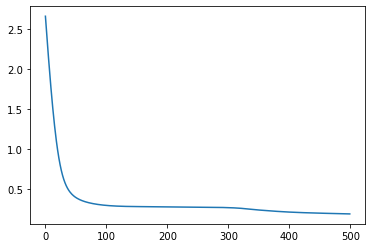

In [13]:
plt.plot(loss_list)
plt.yscale('log')